# PROBLEM 1: Aminer : basic dataset analysis

This is a large dataset (about 2 million publications – it takes about a minute just to parse!). While your notebook must successfully work on the entire dataset, you may find it useful to work on a subset while getting your code to work.

In [4]:
# import modules

import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import difflib
import timeit


In [5]:
# constants and paths

AMINERDATASETPATH = 'data/acm.txt'
SQLITEDB = 'acm.db'


In [3]:
# create sqlite db because tyring to keep this data 
# in memory crashes computer
# reference - https://www.sqlite.org/lang.html
# reference - https://stackoverflow.com/questions/45374921/why-does-timeit-loop-different-number-of-times

def executeSQLCommand(db, command):
    ''' execute sqlitedb commands (not for queries!)'''
    # establish db connection
    conn = sqlite3.connect(db) 
    cursor = conn.cursor()

    #execute command
    cursor.execute(command)
    conn.commit()
    
    conn.close() 

# make a table acm_data to store the data
create_table_command = """
    CREATE TABLE IF NOT EXISTS acm_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        indexValue TEXT,
        authors TEXT,
        publicationName TEXT,
        publicationVenue TEXT,
        publicationDate TEXT,
        citations TEXT,
        UNIQUE(indexValue, authors, publicationName, publicationVenue, publicationDate, citations)
        );
    """

%timeit -r1 executeSQLCommand(SQLITEDB, create_table_command)

89.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


In [4]:
# https://stackoverflow.com/questions/1711631/improve-insert-per-second-performance-of-sqlite
# https://avi.im/blag/2021/fast-sqlite-inserts/
# https://stackoverflow.com/questions/71220057/unpack-tuple-to-format-string
# example entry ('1', '#*', 'MOSFET table look-up models for circuit 
#                simulation'), ('1', '#t', '1984'), ('1', '#c', 
#                'Integration, the VLSI Journal'), ('1', '#index', '1')


def batchInsert(db, txtfilepath, batchsize=1000):
    '''batch insert data from acm.txt into sqlite db in batches'''
    try:
        conn = sqlite3.connect(db) 
        cursor = conn.cursor()
        cursor.execute("PRAGMA synchronous = OFF;")
        cursor.execute("PRAGMA journal_mode = WAL;")
        batch_data = []
        # parse acm.txt and make batches to insert into db
        with open(txtfilepath, 'r') as acm:
            entry = {}
            for line in acm:
                # if its the end of a block (line = \n) append entry to batch data 
                # and if correct batchsize insert batch)
                if not line.strip():
                    if entry:
                        index_value = entry.get('#index', '')
                        authors = ', '.join(entry.get('#@', []))
                        publication_name = ', '.join(entry.get('#*', ''))
                        publication_venue = ', '.join(entry.get('#c', ''))
                        publication_date = ', '.join(entry.get('#t', ''))
                        citations = ', '.join(entry.get('#%', ''))
                        
                        # Append to batch
                        batch_data.append((index_value, authors, publication_name, publication_venue, publication_date, citations))
                        
                        # Insert in batches
                        if len(batch_data) >= batchsize:
                            insertString = """
                                INSERT or IGNORE INTO acm_data (indexValue, authors, publicationName, publicationVenue, publicationDate, citations) 
                                VALUES (?, ?, ?, ?, ?, ?);
                            """
                            cursor.executemany(insertString, batch_data)
                            conn.commit()
                            batch_data = []  

                    entry = {}  
                    continue
    
                # otherwise update entry with data from block of data in file
                elif line.startswith('#index'):
                    entry['#index'] = line.replace('#index', '').strip()
                
                elif line.startswith('#'):
                    key = line[:2]
                    value = line[2:].strip()
                    
                    if key in entry:
                        entry[key].append(value)
                    else:
                            entry[key] = [value]
        
            # add any remaining data less than batch threshold
            if batch_data:
                insertString = """
                    INSERT or IGNORE INTO acm_data (indexValue, authors, publicationName, publicationVenue, publicationDate, citations) 
                    VALUES (?, ?, ?, ?, ?, ?);
                    """
                cursor.executemany(insertString, batch_data)
                conn.commit()
                batch_data = []
    except Exception as e:
        print(e)
    finally:
        conn.close()

%timeit -r1 batchInsert(SQLITEDB, AMINERDATASETPATH, batchsize=1000)

28.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Part A 

Compute the number of distinct authors, publication venues, publications, and citations/references

In [6]:

# create indexes so i dont wait all day for queries
def create_indexes():
    conn = sqlite3.connect(SQLITEDB) 
    cursor = conn.cursor()
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_indexValue ON acm_data(indexValue);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_authors ON acm_data(authors);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_publicationName ON acm_data(publicationName);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_publicationVenue ON acm_data(publicationVenue);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_publicationDate ON acm_data(publicationDate);")
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_citations ON acm_data(citations);")
    conn.close()

%timeit -r1 create_indexes()

525 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
def count_distinct_entries():
    # establish connection
    conn = sqlite3.connect("acm.db")
    cursor = conn.cursor()
    authors_list_raw = cursor.execute("""
        SELECT DISTINCT(authors)
        FROM acm_data 
        WHERE authors != '';
        """).fetchall()
    
    distinct_publication_venues = cursor.execute("""
        SELECT DISTINCT(publicationVenue) 
        FROM acm_data 
        WHERE publicationVenue != '';
        """).fetchall()
    
    distinct_publications = cursor.execute("""
        SELECT DISTINCT(publicationName)
        FROM acm_data 
        WHERE publicationName != '';
        """).fetchall()
    
    citations_raw = cursor.execute("""
        SELECT DISTINCT(citations)
        FROM acm_data 
        WHERE citations != '';
        """).fetchall()
    
    conn.close()
    
    distinct_authors = set(author.strip() for entry in authors_list_raw for author in entry[0].split(',') if any(char.isalnum() for char in author))
    distinct_citations = set(citation.strip() for entry in citations_raw for citation in entry[0].split(',') if any(char.isalnum() for char in citation))
    
    
    print(f'The number of distinct author entries are : {len(distinct_authors)}.')
    print(f'The number of distinct publication venues entries are : {len(distinct_publication_venues)}.')
    print(f'The number of distinct publication entries are : {len(distinct_publications)}.')
    print(f'The number of distinct citation entries are : {len(distinct_citations)}.')
    return (distinct_authors,
           distinct_publication_venues,
           distinct_publications,
           distinct_citations)

#%timeit -r1 need to take print statements out
distinct_authors, distinct_publication_venues, distinct_publications, distinct_citations = count_distinct_entries()

The number of distinct author entries are : 1651585.
The number of distinct publication venues entries are : 273329.
The number of distinct publication entries are : 2183551.
The number of distinct citation entries are : 1007495.


In [8]:
print(distinct_publication_venues)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Part B.

Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases” – what do you notice?

In [7]:

def partB(distinct_publication_venues):
    # Search for close matches using difflib
    print("Close matches (difflib) to 'Principles and Practice of Knowledge Discovery in Databases':\n")
    
    # using distinct_publication_venues from partA
    close_matches = difflib.get_close_matches(
        "Principles and Practice of Knowledge Discovery in Databases", 
        distinct_publication_venues, 
        n=15
    )
    
    for match in close_matches:
        print(match)
    
    # find substring matches
    print("\nSubstring Matches to 'Principles and Practice of Knowledge Discovery in Databases':\n")
    for entry in distinct_publication_venues:
        if "Principles and Practice of Knowledge Discovery in Databases" in entry:
            print(entry)

#%timeit -r1 need to take print statements out
partB(distinct_publication_venues)

Close matches (difflib) to 'Principles and Practice of Knowledge Discovery in Databases':


Substring Matches to 'Principles and Practice of Knowledge Discovery in Databases':



## Part C
For each author, construct the list of publications. Plot a histogram of the number of publications per author (use a logarithmic scale on the y axis)

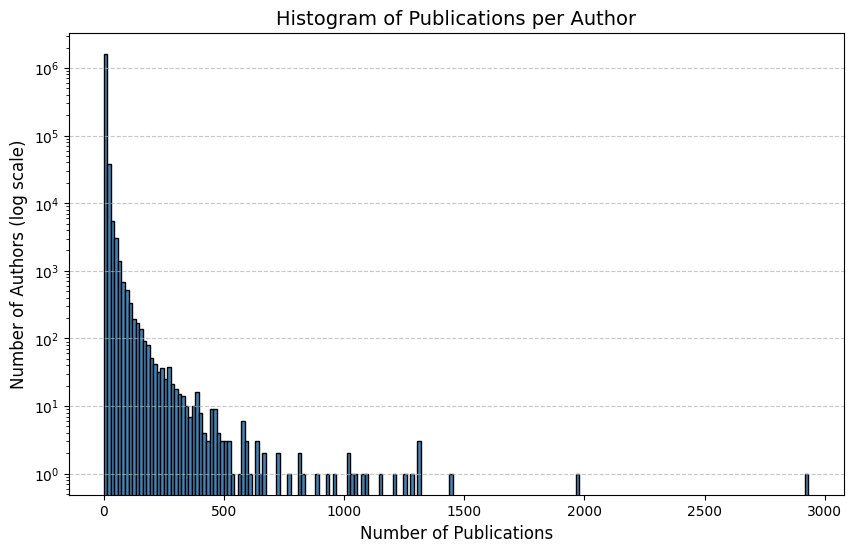

In [3]:

# connect to db
conn = sqlite3.connect("acm_data.db")
cursor = conn.cursor()


conn.commit()

# query database to get all authors and their pub titles
cursor.execute("""
SELECT a.value AS author, p.value AS publication_title
FROM acm_data a
JOIN acm_data p ON a.index_value = p.index_value
WHERE a.key = '#@' AND p.key = '#*';
""")

# parse result
author_publications = defaultdict(list)
for author, publication_title in cursor.fetchall():
    if author and publication_title: 
        author_publications[author].append(publication_title)

# get the number of publications per author
publications_per_author = [len(publications) for publications in author_publications.values()]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(publications_per_author, 
         bins=200, 
         log=True, 
         color='steelblue', 
         edgecolor='black')
plt.title("Histogram of Publications per Author", 
          fontsize=14)
plt.xlabel("Number of Publications", 
           fontsize=12)
plt.ylabel("Number of Authors (log scale)", 
           fontsize=12)
plt.grid(axis='y', 
         linestyle='--', 
         alpha=0.7)
plt.show()

# Close the database connection
conn.close()

In [11]:
# Connect to the SQLite database
conn = sqlite3.connect("acm_data.db")
cursor = conn.cursor()

# Ensure the database is indexed for better performance
cursor.execute("CREATE INDEX IF NOT EXISTS idx_index_key_value ON acm_data (index_value, key, value);")
conn.commit()

# Query the database to count the number of publications per author
cursor.execute("""
SELECT a.value AS author, COUNT(DISTINCT p.value) AS publication_count
FROM acm_data a
JOIN acm_data p ON a.index_value = p.index_value
WHERE a.key = '#@' AND p.key = '#*'
GROUP BY a.value;
""")

# Fetch publication counts
publication_counts = [row[1] for row in cursor.fetchall()]

# Calculate statistics
mean = np.mean(publication_counts)
std_dev = np.std(publication_counts)
q1 = np.percentile(publication_counts, 25)  # 1st quartile
median = np.median(publication_counts)     # 2nd quartile (median)
q3 = np.percentile(publication_counts, 75)  # 3rd quartile

# Print results
print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Q1 (1st Quartile): {q1}")
print(f"Median (Q2): {median}")
print(f"Q3 (3rd Quartile): {q3}")

# Close the database connection
conn.close()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
del acm_dict